In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import yaml
import shutil
from datetime import datetime

sns.set_theme()

In [2]:
### All global variables that would be passed as arguments in a python script
input_csv_file = "/home/nils/Downloads/latency_per_task_buffer.csv"


def load_data():
    df = pd.read_csv(input_csv_file)
    # Remove rows that are equal to the header
    header = df.columns.tolist()
    df = df[~(df == header).all(axis=1)]

    # Converting some columns to float
    for col in ['SequenceNumber', 'StartTimeInUs', 'EndTimeInUs','NumberOfTuplesInput','Selectivity','NumberOfWorkerThreads','Skewness', 'OriginId']:
        df[col] = df[col].astype(float).fillna(0.0)

    df['LatencyInUS'] = df['EndTimeInUs'] - df['StartTimeInUs']

    df = df.sort_values(by='SequenceNumber').reset_index(drop=True)
    return df

df = load_data()
df

/tmp/ipykernel_66297/499830118.py:6: DtypeWarning: Columns (0,1,2,3,4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv_file)


,SequenceNumber,StartTimeInUs,EndTimeInUs,NumberOfTuplesInput,Selectivity,ProviderName,NumberOfWorkerThreads,Skewness,OriginId,LatencyInUS
0,1.0,1.740133e+15,1.740133e+15,1.0,10.0,Compilation,1.0,0.0,8.0,31183.0
1,1.0,1.740133e+15,1.740133e+15,1.0,10.0,Compilation,16.0,0.0,18.0,30681.0
2,1.0,1.740133e+15,1.740133e+15,3000.0,10.0,Compilation,16.0,0.0,3.0,1100.0
3,1.0,1.740133e+15,1.740133e+15,3000.0,10.0,Compilation,16.0,0.0,9.0,1167.0
4,1.0,1.740133e+15,1.740133e+15,3000.0,10.0,Compilation,16.0,0.0,18.0,1205.0
...,...,...,...,...,...,...,...,...,...,...
1800589,100000.0,1.740133e+15,1.740133e+15,1.0,90.0,Compilation,1.0,0.0,18.0,38124.0
1800590,100000.0,1.740133e+15,1.740133e+15,1.0,50.0,Compilation,1.0,0.0,7.0,34759.0
1800591,100000.0,1.740133e+15,1.740133e+15,1.0,10.0,Compilation,1.0,0.0,13.0,39081.0
1800592,100000.0,1.740133e+15,1.740133e+15,1.0,90.0,Compilation,16.0,0.0,17.0,84579.0


In [3]:
df = load_data()

x_param="SequenceNumber"
y_params = ["NumberOfTuplesInput"]
y_param_units = ["No. Tuples"]
hue="Skewness"


subset = df[df['NumberOfWorkerThreads'] == 1]
subset = subset[subset['Selectivity'] == 10]
subset = subset[['SequenceNumber', 'NumberOfTuplesInput', 'OriginId', 'StartTimeInUs', 'EndTimeInUs']]

print("Number of Unique Values per Column:")
print(subset.nunique(), "\n")


/tmp/ipykernel_66297/499830118.py:6: DtypeWarning: Columns (0,1,2,3,4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv_file)


Number of Unique Values per Column:
SequenceNumber         100000
NumberOfTuplesInput         2
OriginId                   20
StartTimeInUs           87352
EndTimeInUs            101270
dtype: int64 



/tmp/ipykernel_66297/499830118.py:6: DtypeWarning: Columns (0,1,2,3,4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv_file)


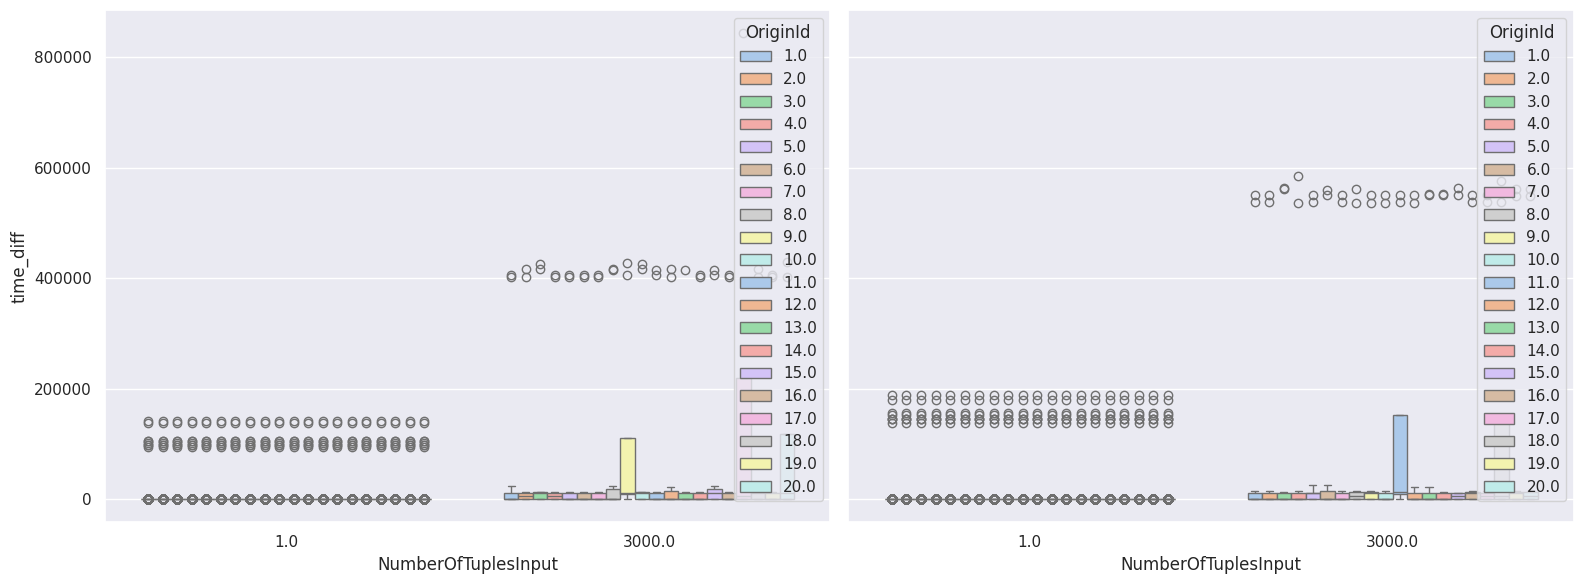

,OriginId,NumberOfWorkerThreads,NumberOfTuplesInput,time_diff
815,1.0,1.0,1.0,NaN
1633,1.0,1.0,1.0,20.0
1916,1.0,1.0,1.0,6.0
3143,1.0,1.0,1.0,26.0
3471,1.0,1.0,1.0,6.0
...,...,...,...,...
1799940,20.0,16.0,1.0,2.0
1800023,20.0,16.0,1.0,0.0
1800473,20.0,16.0,1.0,8.0
246,20.0,16.0,3000.0,548846.0


In [9]:
df = load_data()
df = df[df['ProviderName'] == "Compilation"]

# Sort by 'originid' and 'timestamp'
df = df.sort_values(by=['OriginId', 'StartTimeInUs', 'NumberOfWorkerThreads', 'NumberOfTuplesInput'])

# Calculate time differences within each 'originid'
df['time_diff'] = df.groupby(['OriginId', 'NumberOfWorkerThreads', 'NumberOfTuplesInput'])['StartTimeInUs'].diff()

df = df[['OriginId', 'NumberOfWorkerThreads', 'NumberOfTuplesInput', 'time_diff']]


interesting_param = 'NumberOfWorkerThreads'
unique_params = df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(1, n_params, figsize=(16, 6), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = df[df[interesting_param] == param]  
    
    ax = axes[0][idx]
    sns.boxplot(x='NumberOfTuplesInput', hue='OriginId', y='time_diff', data=subset, ax=ax, palette="pastel")
    #ax.set_title(f"Latency vs {x_param} for {param} % Selectivity")
    #ax.set_xlabel(x_param)
    #ax.set_ylabel(y_param_units[0])
    #ax.set_ylim([0, .04])

plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

/tmp/ipykernel_66297/499830118.py:6: DtypeWarning: Columns (0,1,2,3,4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv_file)


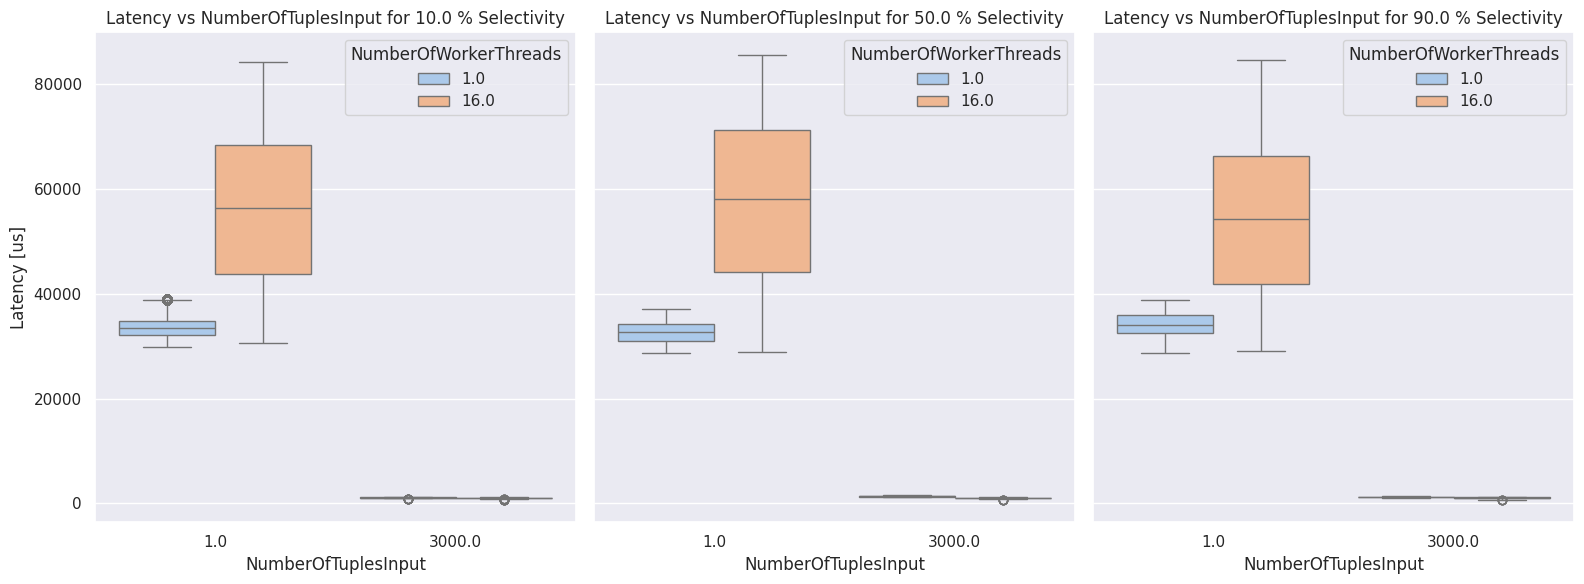

In [5]:
df = load_data()
df = df[df['ProviderName'] == "Compilation"]


interesting_param = "Selectivity"
x_param="NumberOfTuplesInput"
y_params = ["LatencyInUS"]
y_param_units = ["Latency [us]"]
hue="NumberOfWorkerThreads"


unique_params = df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(1, n_params, figsize=(16, 6), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = df[df[interesting_param] == param]  
    
    ax = axes[0][idx]
    sns.boxplot(x=x_param, y=y_params[0], hue=hue, data=subset, ax=ax, palette="pastel")
    ax.set_title(f"Latency vs {x_param} for {param} % Selectivity")
    ax.set_xlabel(x_param)
    ax.set_ylabel(y_param_units[0])
    #ax.set_ylim([0, .04])

plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

In [6]:
df = load_data()

x_param="SequenceNumber"
y_params = ["NumberOfTuplesInput"]
y_param_units = ["No. Tuples"]
hue="Skewness"


subset = df[df['NumberOfWorkerThreads'] == 1]
subset = subset[subset['Selectivity'] == 10]
subset = subset[['SequenceNumber', 'NumberOfTuplesInput', 'Skewness']]
subset

/tmp/ipykernel_66297/499830118.py:6: DtypeWarning: Columns (0,1,2,3,4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv_file)


,SequenceNumber,NumberOfTuplesInput,Skewness
0,1.0,1.0,0.0
19,1.0,1.0,0.0
20,1.0,3000.0,0.0
21,1.0,3000.0,0.0
22,1.0,3000.0,0.0
...,...,...,...
1800570,99999.0,1.0,0.0
1800573,99999.0,1.0,0.0
1800576,100000.0,1.0,0.0
1800587,100000.0,1.0,0.0


/tmp/ipykernel_66297/499830118.py:6: DtypeWarning: Columns (0,1,2,3,4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv_file)


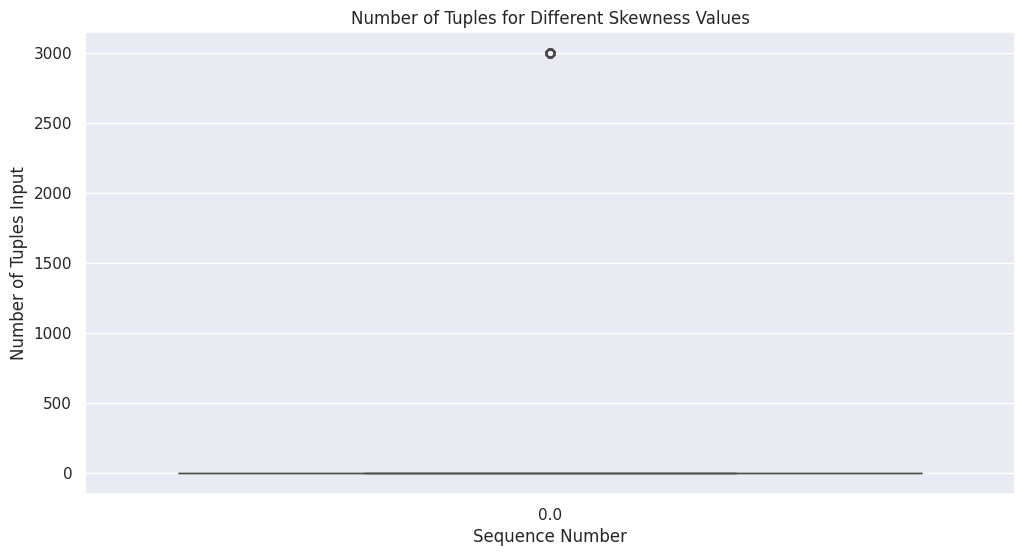

In [7]:
df = load_data()

x_param="SequenceNumber"
y_params = ["NumberOfTuplesInput"]
y_param_units = ["No. Tuples"]
#hue="Skewness"


subset = df[df['NumberOfWorkerThreads'] == 1]
subset = subset[subset['Selectivity'] == 10]
subset = subset[['SequenceNumber', 'NumberOfTuplesInput', 'Skewness']]


# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(x='Skewness', y='NumberOfTuplesInput', data=subset)
plt.title('Number of Tuples for Different Skewness Values')
plt.xlabel('Sequence Number')
plt.ylabel('Number of Tuples Input')
plt.show()


/tmp/ipykernel_66297/499830118.py:6: DtypeWarning: Columns (0,1,2,3,4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv_file)


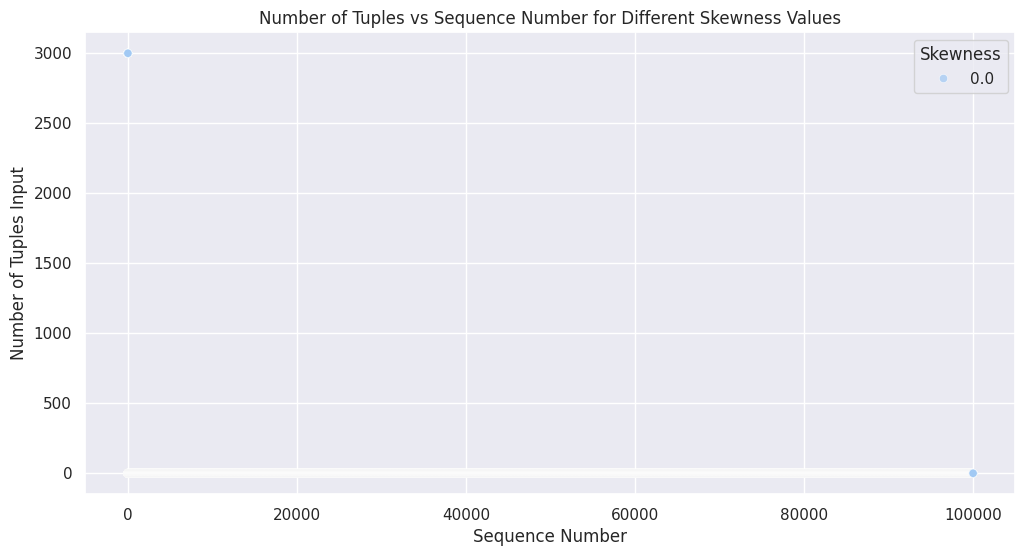

In [8]:
df = load_data()

x_param="SequenceNumber"
y_params = ["NumberOfTuplesInput"]
y_param_units = ["No. Tuples"]
hue="Skewness"


subset = df[df['NumberOfWorkerThreads'] == 1]
subset = subset[subset['Selectivity'] == 10]
subset = subset[['SequenceNumber', 'NumberOfTuplesInput', 'Skewness']]


# Plotting
plt.figure(figsize=(12, 6))
sns.scatterplot(x='SequenceNumber', y='NumberOfTuplesInput', hue='Skewness', data=subset, palette='pastel', alpha=0.7)
plt.title('Number of Tuples vs Sequence Number for Different Skewness Values')
plt.xlabel('Sequence Number')
plt.ylabel('Number of Tuples Input')
plt.legend(title='Skewness')
plt.show()